In [42]:
import sys

sys.path.append("..")

import pickle as pkl

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from cbdetect_py import CornerType, Params, boards_from_corners, find_corners
from ipywidgets import FloatSlider, IntRangeSlider, interact
from pandas.compat import os
from PIL import Image, ImageOps
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

from calibration.benchmark.benchmark import (
    BenchmarkResult,
    benchmark_babelcalib,
    benchmark_simul,
)
from calibration.data.babelcalib.babelcalib import load_babelcalib
from calibration.data.babelcalib.entry import Entry
from calibration.feature_detector.checkerboard import detect_corners
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.feature_refiner.refine import refine_features_single

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open("../babelcalib_results.pkl", "rb") as f:
    results = pkl.load(f)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
key = "OV/cube/ov00", "train", "ov00/0031.pgm"
r = next(
    r for r in results if (r.input.ds_name, r.input.subds_name, r.input.name) == key
)

{'Scaramuzza': 3.859001445360994, 'Optimization': 2.172066414282015}


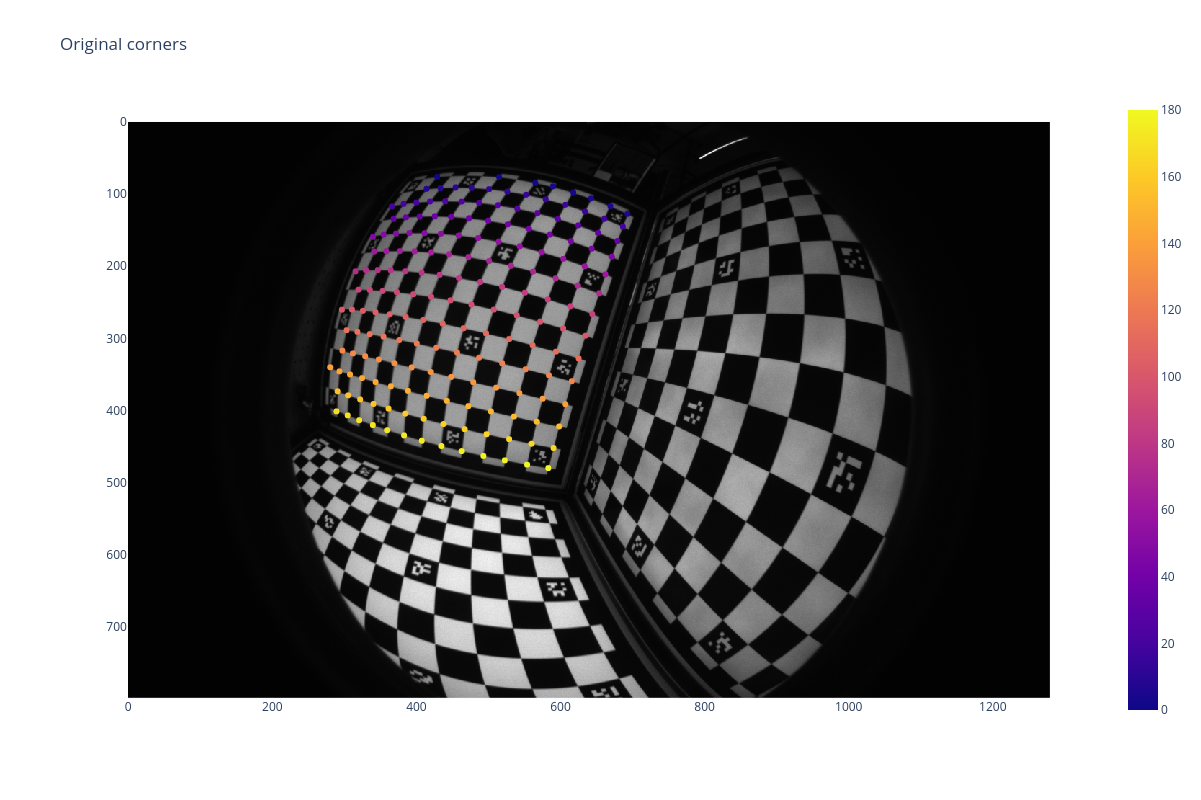

In [12]:
w, h = r.input.image.size

print(r.errors)
show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    height=h, width=w, title="Original corners"
)

In [38]:
ref_r = refine_features_single(r)

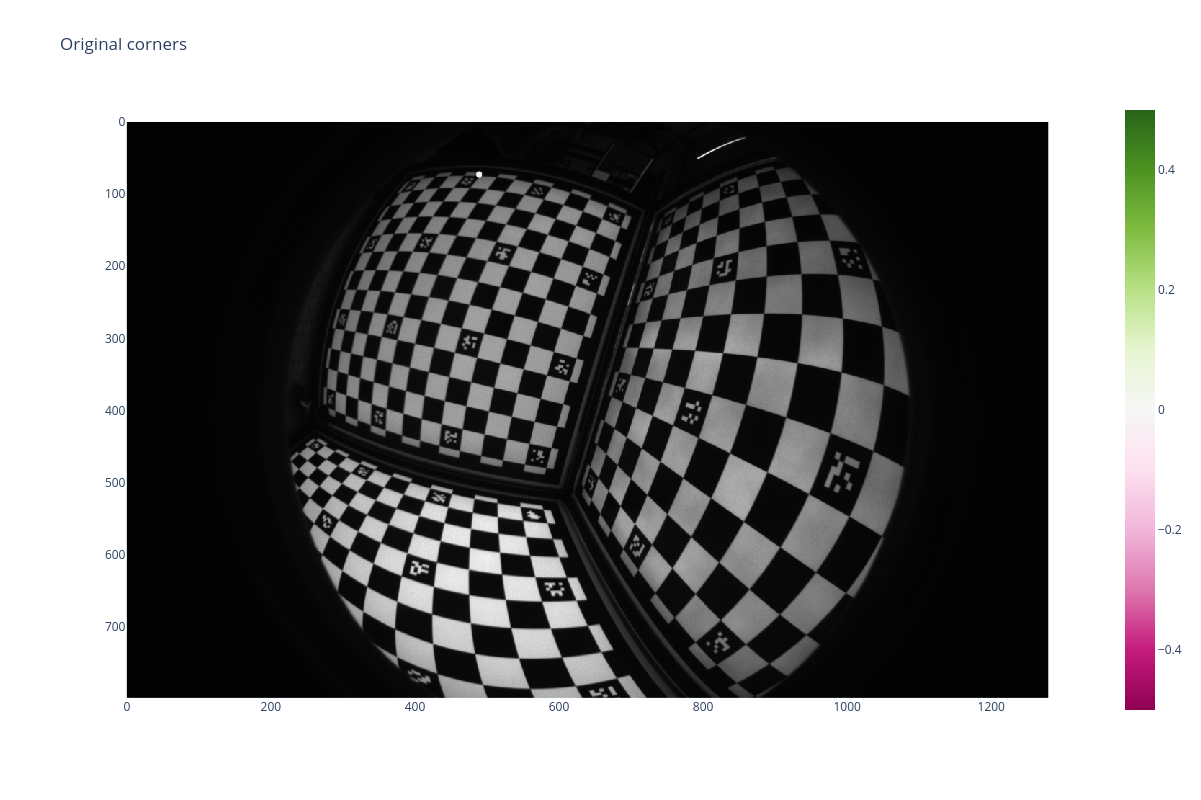

In [36]:
show_boards(
    ref_r.input.image,
    ref_r.refined_features.corners[ref_r.new_board_mask == 2],
    ref_r.refined_features.board[ref_r.new_board_mask == 2],
).update_layout(height=h, width=w, title="Refined corners")

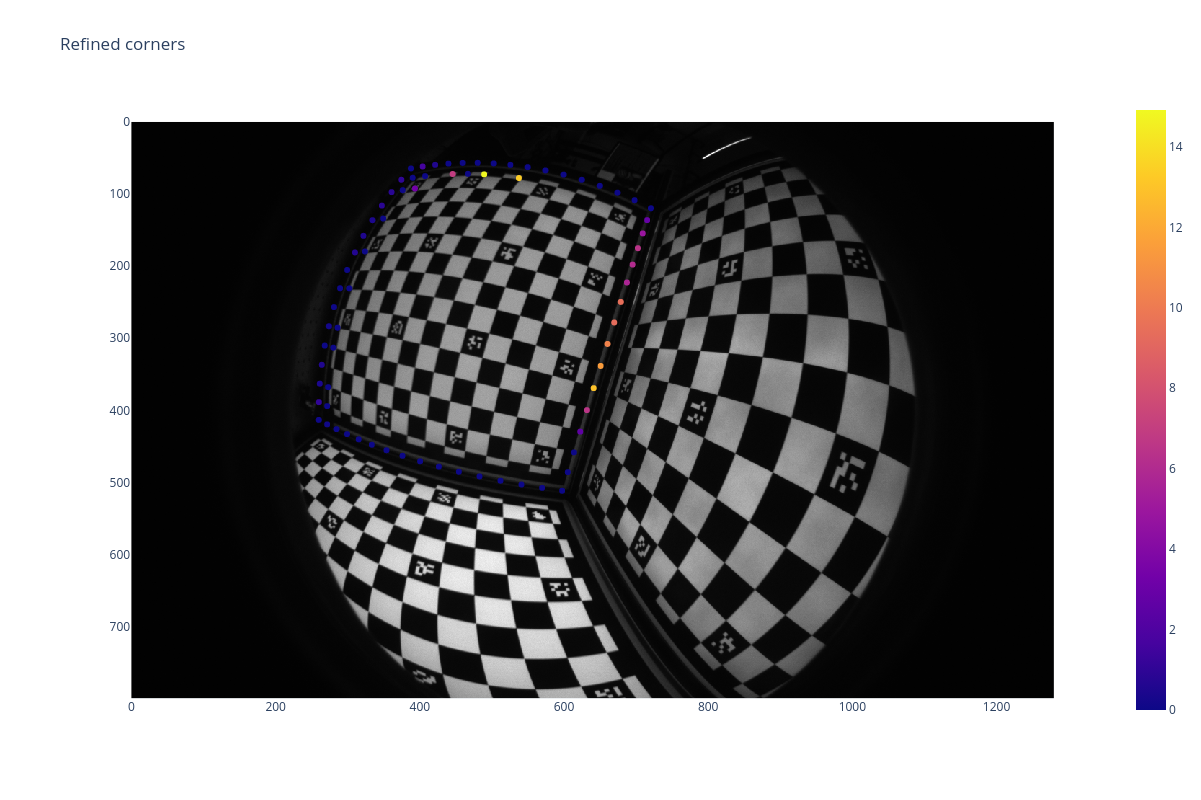

In [45]:
fig1 = px.imshow(ref_r.input.image, binary_string=True)

corners, board = (
    ref_r.refined_features.corners[ref_r.new_board_mask > 0],
    ref_r.refined_features.board[ref_r.new_board_mask > 0],
)
points = [
    {
        "n": i,
        "i": feature[0],
        "j": feature[1],
        "x": corner[0],
        "y": corner[1],
        "response": response,
    }
    for i, (corner, feature, response) in enumerate(
        zip(corners, board, ref_r.responses)
    )
]
df = pd.DataFrame(points)
fig2 = px.scatter(df, x="x", y="y", color="response", hover_data=["i", "j"])
go.Figure(data=[fig1.data[0], fig2.data[0]]).update_layout(
    height=h, width=w, title="Refined corners"
)